# Ring broadcast experiment

In this experiment, N ranks perform a ring broadcast. We measure the duration of the individual calls to `MPI_Recv` and `MPI_Send`.

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.BaseLoader)

def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    for df in [df_send, df_recv, df_ringrong]:
        df['cluster'] = info['cluster']
        df['matrix_size'] = int(install['matrix_size'])
        df['reuse_buffer'] = install['reuse_buffer']
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

In [2]:
directory = 'ring/5/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
df = pandas.concat([load_ringrong(f)['recv'] for f in archives])
df['matrix_size'] = pandas.Categorical(df['matrix_size'], categories=df[['matrix_size']].drop_duplicates().sort_values(by='matrix_size')['matrix_size'], ordered=True)
df

,index,function,rank,op_id,timestamp,duration,msg_size,sub_id,op_kind,experiment,cluster,matrix_size,reuse_buffer
1,1,MPI_Recv,0,0,0.000031,3.265567e-02,8,0,recv-send,remote,dahu,96,False
2,2,MPI_Recv,0,0,0.069241,5.450000e-06,8,1,send-recv,loopback,dahu,96,False
5,5,MPI_Recv,0,1,0.069647,8.655100e-05,8,2,recv-send,remote,dahu,96,False
6,6,MPI_Recv,0,1,0.076892,1.442000e-06,8,3,send-recv,loopback,dahu,96,False
9,9,MPI_Recv,0,2,0.076900,7.124500e-05,8,4,recv-send,remote,dahu,96,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
721911,721911,MPI_Recv,63,2817,5307.138489,2.069540e-04,1002,360955,send-recv,remote,dahu,96,True
721912,721912,MPI_Recv,63,2818,5307.144152,2.381000e-06,1002,360956,recv-send,loopback,dahu,96,True
721915,721915,MPI_Recv,63,2818,5307.144162,2.726920e-04,1002,360957,send-recv,remote,dahu,96,True
721916,721916,MPI_Recv,63,2819,5307.150597,8.660000e-07,1002,360958,recv-send,loopback,dahu,96,True


In [3]:
function = df['function'].unique()
assert len(function) == 1
function = function[0]
function

'MPI_Recv'

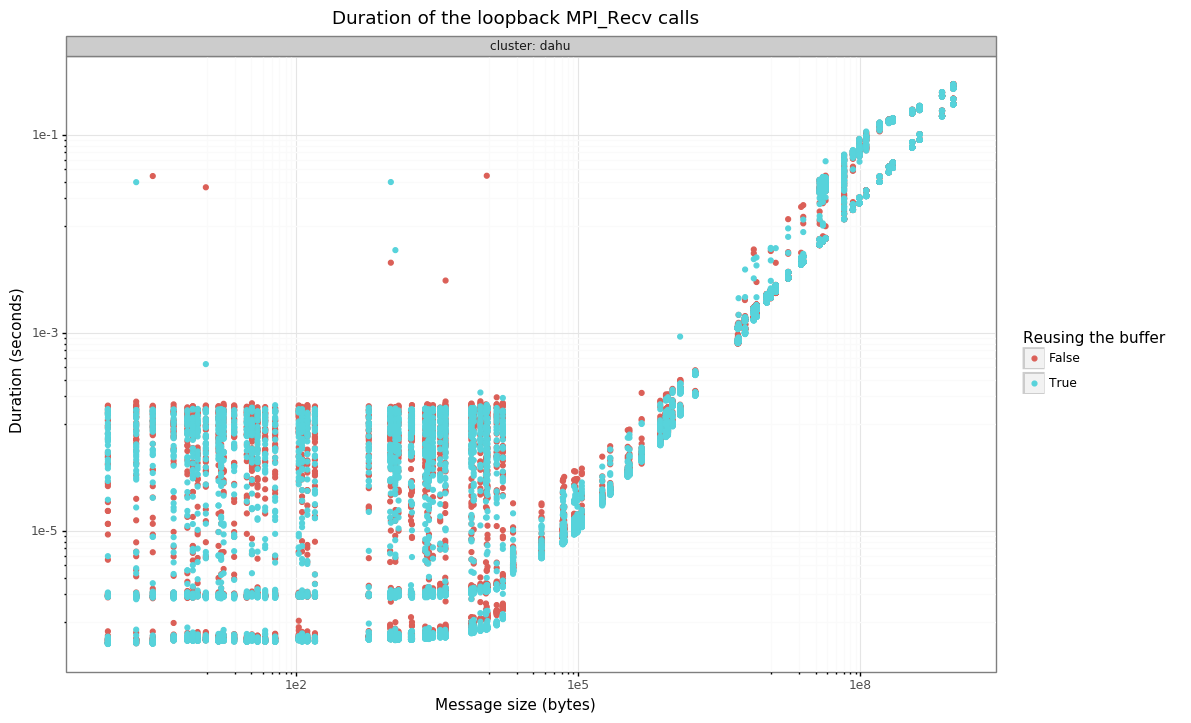

<ggplot: (8781020912616)>

In [4]:
(ggplot(df[(df['rank'] == 3)])
    + aes(x='msg_size', y='duration', color='factor(reuse_buffer)')
    + geom_point() 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('cluster', labeller='label_both')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Reusing the buffer')
    + ggtitle(f'Duration of the loopback {function} calls')
)

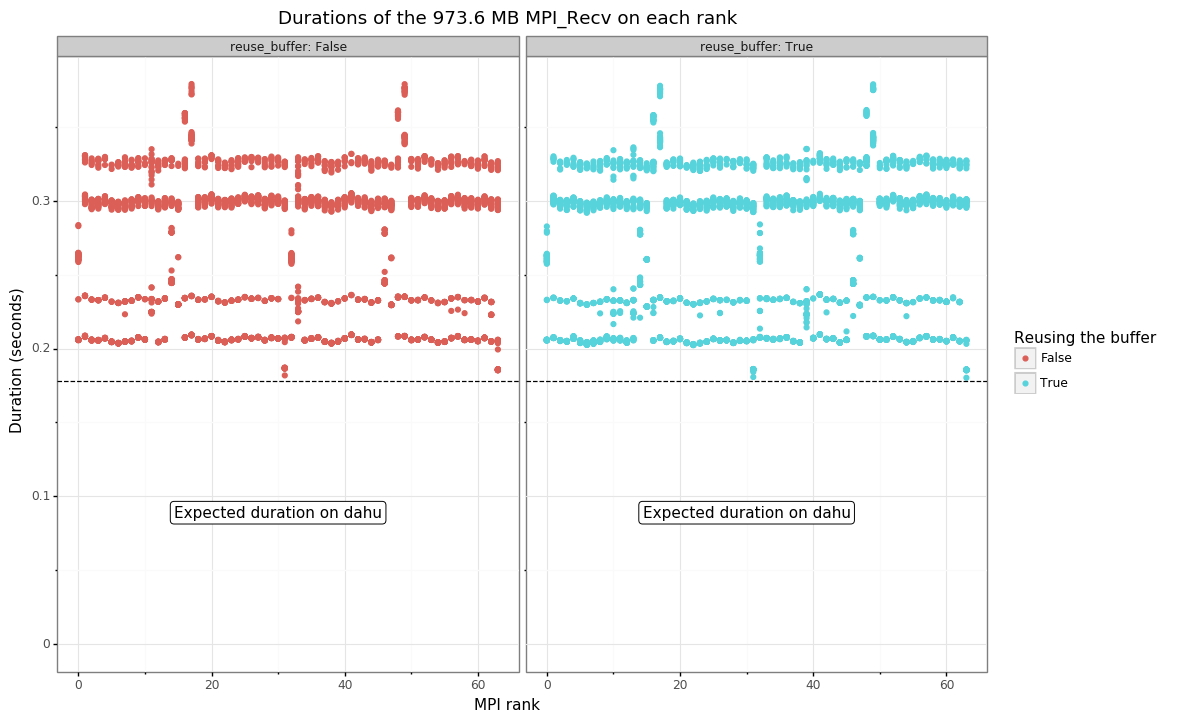

<ggplot: (8781020866557)>

In [5]:
df['size'] = df['msg_size']
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df['size'].max()
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='reuse_buffer')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap('reuse_buffer', labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Reusing the buffer')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank')
)

221569716


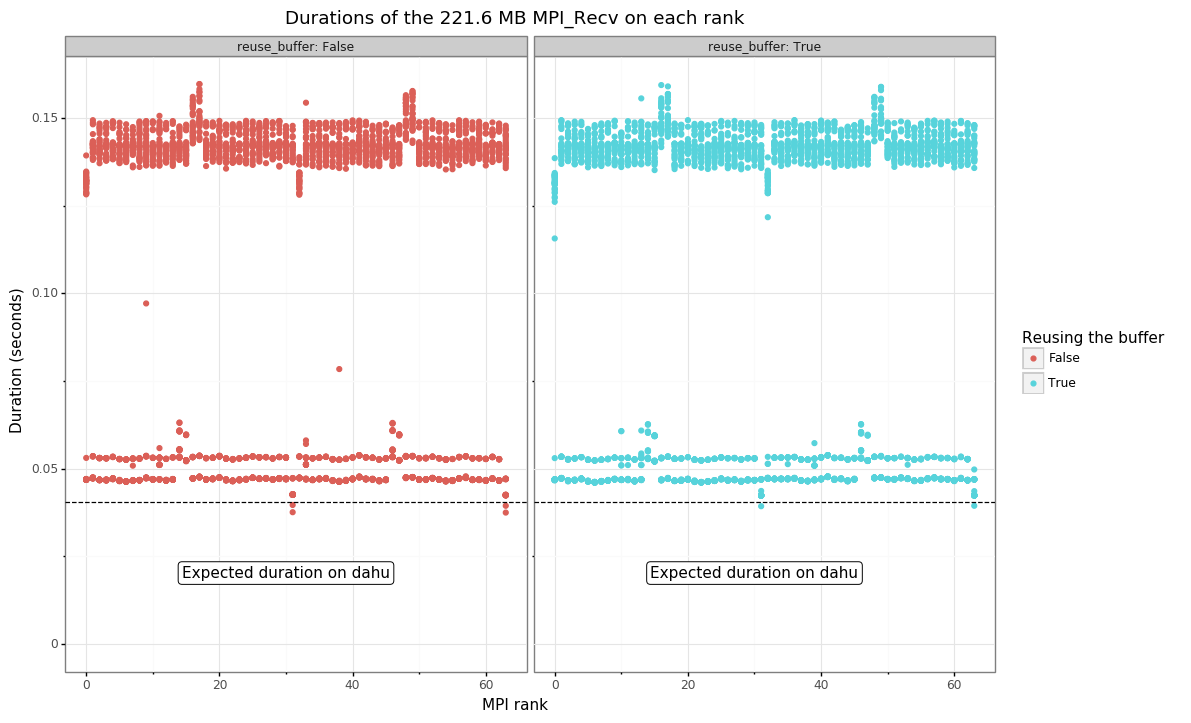

<ggplot: (-9223363255835619324)>

In [6]:
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df[df['size'] < 3e8]['size'].max()
print(size)
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='reuse_buffer')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + facet_wrap('reuse_buffer', labeller='label_both')
    + labs(x='MPI rank', y='Duration (seconds)', color='Reusing the buffer')
    + annotate('label', x=30, y=theoretical_duration*0.5, label='Expected duration on dahu')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB {function} on each rank')
)